# Evaluating your SAE

Code based off Rob Graham's ([themachinefan](https://github.com/themachinefan)) SAE evaluation code.

In [22]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [23]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [25]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig

@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    sae_path: str = '/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32

    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [26]:
torch.set_grad_enabled(False)

## Load model

In [27]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [28]:
import importlib
import vit_prisma
# importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [29]:
# load dataset
import open_clip
from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

from torchvision import transforms
from transformers import CLIPProcessor

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
processor = preproc

size=224

data_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                     std=[0.26862954, 0.26130258, 0.27577711]),
])
    
imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
print()
train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'], 
                                data_transforms,
                                return_index=True,
)
val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
                                imagenet_paths['label_strings'], 
                                imagenet_paths['val_labels'],
                                torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),]), return_index=True)

print(f"Validation data length: {len(val_data)}") if cfg.verbose else None



Validation data length: 50000


In [30]:
from vit_prisma.sae.training.activations_store import VisionActivationsStore
# import dataloader
from torch.utils.data import DataLoader

# activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [31]:
from vit_prisma.sae.sae import SparseAutoencoder
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained("/workspace/sae_checkpoints/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/n_images_2600058.pt")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 


get_activation_fn received: activation_fn=relu, kwargs={}
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 1586
Expansion factor: 64
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
get_activation_fn received: activation_fn=relu, kwargs={}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

# Maximally activating images

In [34]:
interesting_features_indices = [665, 2541]
interesting_features_category = ["TOTAL_"] * len(interesting_features_indices)

In [35]:
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

@torch.no_grad()
def compute_feature_activations(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10
) -> Dict[int, Tuple[torch.Tensor, torch.Tensor]]:
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
    _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    
    layer_activations = cache[sparse_autoencoder.cfg.hook_point]
    batch_size, seq_len, _ = layer_activations.shape
    flattened_activations = einops.rearrange(layer_activations, "batch seq d_mlp -> (batch seq) d_mlp")
    
    sae_input = flattened_activations - sparse_autoencoder.b_dec
    feature_activations = einops.einsum(sae_input, encoder_weights, "... d_in, d_in n -> ... n") + encoder_biases
    feature_activations = torch.nn.functional.relu(feature_activations)
    
    reshaped_activations = einops.rearrange(feature_activations, "(batch seq) d_in -> batch seq d_in", batch=batch_size, seq=seq_len)
    cls_token_activations = reshaped_activations[:, 0, :]
    mean_image_activations = reshaped_activations.mean(1)

    top_activations = {}
    for i, (feature_id, feature_category) in enumerate(zip(feature_ids, feature_categories)):
        if "CLS_" in feature_category:
            top_values, top_indices = cls_token_activations[:, i].topk(top_k)
        else:
            top_values, top_indices = mean_image_activations[:, i].topk(top_k)
        top_activations[feature_id] = (top_indices, top_values)
    
    return top_activations

def find_top_activations(
    val_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    cfg: object,
    interesting_features_indices: List[int],
    interesting_features_category: List[str],
    top_k: int = 16,
) -> Dict[int, Tuple[torch.Tensor, torch.Tensor]]:
    """
    Find the top activations for interesting features across the validation dataset.

    Args:
        val_dataloader: Validation data loader
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        cfg: Configuration object
        interesting_features_indices: Indices of interesting features
        interesting_features_category: Categories of interesting features

    Returns:
        Dictionary mapping feature IDs to tuples of (top_values, top_indices)
    """
    max_samples = cfg.eval_max

    top_activations = {i: (None, None) for i in interesting_features_indices}
    encoder_biases = sparse_autoencoder.b_enc[interesting_features_indices]
    encoder_weights = sparse_autoencoder.W_enc[:, interesting_features_indices]

    processed_samples = 0
    for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
        batch_images = batch_images.to(cfg.device)
        batch_indices = batch_indices.to(cfg.device)
        batch_size = batch_images.shape[0]

        batch_activations = compute_feature_activations(
            batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
            interesting_features_indices, interesting_features_category, top_k
        )

        for feature_id in interesting_features_indices:
            new_indices, new_values = batch_activations[feature_id]
            new_indices = batch_indices[new_indices]
            
            if top_activations[feature_id][0] is None:
                top_activations[feature_id] = (new_values, new_indices)
            else:
                combined_values = torch.cat((top_activations[feature_id][0], new_values))
                combined_indices = torch.cat((top_activations[feature_id][1], new_indices))
                _, top_k_indices = torch.topk(combined_values, top_k)
                top_activations[feature_id] = (combined_values[top_k_indices], combined_indices[top_k_indices])

        processed_samples += batch_size
        if processed_samples >= max_samples:
            break

    return {i: (values.detach().cpu(), indices.detach().cpu()) 
            for i, (values, indices) in top_activations.items()}

# Usage
top_activations_per_feature = find_top_activations(
    val_dataloader, model, sparse_autoencoder, cfg,
    interesting_features_indices, interesting_features_category
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1562/1562 [01:11<00:00, 21.76it/s]


### Saves maximally activating images

In [36]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [42]:
import matplotlib.pyplot as plt

torch.no_grad()
def get_heatmap(
          image,
          model,
          sparse_autoencoder,
          feature_id,
): 
    image = image.to(cfg.device)
    _, cache = model.run_with_cache(image.unsqueeze(0))

    post_reshaped = einops.rearrange(cache[sparse_autoencoder.cfg.hook_point], "batch seq d_mlp -> (batch seq) d_mlp")
    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code is copied from the first part of the 'forward' method of the AutoEncoder class
    sae_in =  post_reshaped - sparse_autoencoder.b_dec # Remove decoder bias as per Anthropic
    acts = einops.einsum(
            sae_in,
            sparse_autoencoder.W_enc[:, feature_id],
            "x d_in, d_in -> x",
        )
    return acts 
     
def image_patch_heatmap(activation_values,image_size=224, pixel_num=14):
    activation_values = activation_values.detach().cpu().numpy()
    activation_values = activation_values[1:]
    activation_values = activation_values.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values[i, j]

    return heatmap

    # Removing axes


from collections import defaultdict, Counter
max_activ_img_labels = defaultdict(Counter)
# interesting_features_category are used here, no longer needed
for feature_ids, cat in tqdm(zip(top_activations_per_feature.keys(), interesting_features_category), total=len(interesting_features_category)):
    # need to output the images in a subfolder, not a figure with them
    max_vals, max_inds = top_activations_per_feature[feature_ids]
    images = []
    model_images = []
    gt_labels = []
    for bid, v in zip(max_inds, max_vals):
        image, label, image_ind = val_data_visualize[bid]

        assert image_ind.item() == bid
        images.append(image)

        # I think we're looking for model_image??
        gt_labels.append(ind_to_name[str(label)][1])

    complete_bid = []

    folder = os.path.join(cfg.max_image_output_folder, f"{cat}")
    os.makedirs(folder, exist_ok=True)
    for i, (image_tensor, label, val, bid) in enumerate(zip(images, gt_labels, max_vals,max_inds)):
        if bid in complete_bid:
            continue 
        complete_bid.append(bid)

        newlabel = label.replace("'", "_").replace("-", "_")
        max_activ_img_labels[feature_ids][newlabel] += 1
        print(f"feature_id:{feature_ids}label:{newlabel}bid:{bid}.png")
        savethis = image_tensor.numpy().transpose(1, 2, 0)
        plt.imsave(os.path.join(folder, f"feature_id:{feature_ids}label:{newlabel}bid:{bid}.png"), savethis)
    plt.close()


  0%|                                                                                                               | 0/2 [00:00<?, ?it/s]

feature_id:665label:three_toed_slothbid:45062.png
feature_id:665label:indribid:34640.png
feature_id:665label:titibid:29107.png
feature_id:665label:howler_monkeybid:12710.png
feature_id:665label:titibid:2716.png
feature_id:665label:capuchinbid:41045.png
feature_id:665label:titibid:33926.png
feature_id:665label:three_toed_slothbid:20653.png
feature_id:665label:three_toed_slothbid:13699.png
feature_id:665label:three_toed_slothbid:29889.png
feature_id:665label:howler_monkeybid:3117.png
feature_id:665label:three_toed_slothbid:43099.png


 50%|███████████████████████████████████████████████████▌                                                   | 1/2 [00:02<00:02,  2.89s/it]

feature_id:665label:squirrel_monkeybid:9946.png
feature_id:665label:indribid:3499.png
feature_id:665label:indribid:43256.png
feature_id:665label:indribid:29287.png
feature_id:2541label:African_crocodilebid:41979.png
feature_id:2541label:African_crocodilebid:21108.png
feature_id:2541label:African_crocodilebid:40997.png
feature_id:2541label:American_alligatorbid:20585.png
feature_id:2541label:African_crocodilebid:42026.png
feature_id:2541label:alligator_lizardbid:10910.png
feature_id:2541label:American_chameleonbid:22281.png
feature_id:2541label:axolotlbid:17273.png
feature_id:2541label:African_crocodilebid:17962.png
feature_id:2541label:American_alligatorbid:18665.png
feature_id:2541label:American_alligatorbid:1337.png
feature_id:2541label:common_iguanabid:35280.png
feature_id:2541label:American_alligatorbid:33133.png
feature_id:2541label:green_lizardbid:63.png


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]

feature_id:2541label:agamabid:29879.png
feature_id:2541label:Komodo_dragonbid:3864.png


In [43]:
max_activ_img_labels

defaultdict(collections.Counter,
            {665: Counter({'three_toed_sloth': 5,
                      'indri': 4,
                      'titi': 3,
                      'howler_monkey': 2,
                      'capuchin': 1,
                      'squirrel_monkey': 1}),
             2541: Counter({'African_crocodile': 5,
                      'American_alligator': 4,
                      'alligator_lizard': 1,
                      'American_chameleon': 1,
                      'axolotl': 1,
                      'common_iguana': 1,
                      'green_lizard': 1,
                      'agama': 1,
                      'Komodo_dragon': 1})})

In [38]:
folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-0.0001/layer_9/TOTAL_'

In [ ]:
for filename in os.listdir(folder):
    print(filename)
    plt.imshow(plt.imread(f"{folder}/{filename}"))
    plt.show()


In [22]:
# image tensor, imagenet label, index in dataset
val_data_visualize[29566]

(tensor([[[0.0078, 0.0078, 0.0118,  ..., 0.0078, 0.0078, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
          [0.0157, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
          ...,
          [0.0118, 0.0157, 0.0118,  ..., 0.0157, 0.0157, 0.0157],
          [0.0118, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0118, 0.0157,  ..., 0.0196, 0.0157, 0.0157]],
 
         [[0.0078, 0.0078, 0.0118,  ..., 0.0078, 0.0078, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
          [0.0157, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
          ...,
          [0.0118, 0.0157, 0.0118,  ..., 0.0157, 0.0157, 0.0157],
          [0.0118, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0157],
          [0.0157, 0.0118, 0.0157,  ..., 0.0196, 0.0157, 0.0157]],
 
         [[0.0078, 0.0078, 0.0118,  ..., 0.0078, 0.0078, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
          [0.0157, 0.0118, 0.0118,  ...,

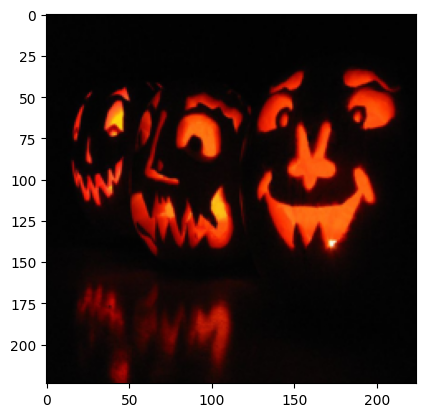

In [28]:
# imsave this to the correct directory (has same name as image but contains all max activ. imagenet imgs)
plt.imshow(  val_data_visualize[29566][0].permute(1, 2, 0)  )
plt.imsave("/workspace/pumpkintest.png",  val_data_visualize[29566][0].permute(1, 2, 0).numpy()  )

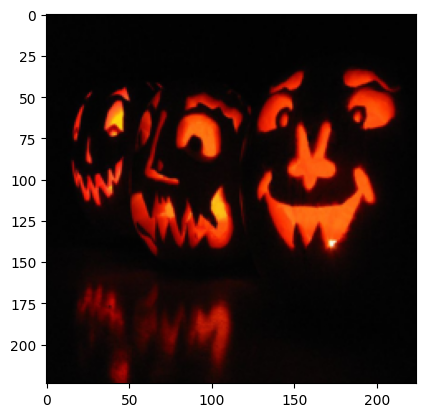

In [29]:
plt.imshow(plt.imread("/workspace/pumpkintest.png"))

In [20]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-2-hook_mlp_out-l1-0.0001/layer_9'

### MAI Interp Experiments

### Clip Labeling AutoInterp

In [23]:
# all_imagenet_class_names

In [20]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [11]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-8e-05/layer_9'

In [ ]:
from PIL import Image
import os
import IPython


dir_feat_sets = {}
feat_ids_by_band = {}
feat_ids = []
imgnet_labels = []
ds_ids = []
selected_dir = 'TOTAL_logfreq_[-2,-1]'
for dir_name in [selected_dir]:
    print(os.listdir(cfg.max_image_output_folder + "/" + dir_name))
    print(len(os.listdir(cfg.max_image_output_folder + "/" + dir_name)))
    images = []
    img_dir = cfg.max_image_output_folder + "/" + dir_name
    i = 0
    dir_feats = set()
    for imagefile in os.listdir(img_dir)[:500]:
        print(i)
        print(imagefile)
        _, feat_id, imgnet_label, ds_id = imagefile.split(":")
        feat_ids_by_band[feat_id] = dir_name
        dir_feats.add(feat_id)
        feat_ids.append(feat_id)
        imgnet_labels.append(imgnet_label)
        ds_ids.append(ds_id)
        i += 1
        IPython.display.Image(img_dir + "/" +imagefile)
        try:
            image = preproc(Image.open(img_dir + "/" + imagefile))
            images.append(image)
        except Exception as e:
            print(e)
    with torch.no_grad(), torch.cuda.amp.autocast():
        feature_ma_image_embeds = og_model.cuda().encode_image(torch.stack(images).cuda())
    dir_feat_sets[dir_name] = dir_feats

In [24]:
tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(all_imagenet_class_names)
text_features = og_model.encode_text(text.cuda())


In [25]:
feature_ma_image_embeds.dtype, text_features.dtype

(torch.float16, torch.float32)

In [ ]:
feature_ma_image_embeds /= feature_ma_image_embeds.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
text_probs = (100.0 * feature_ma_image_embeds.float() @ text_features.T).softmax(dim=-1)

In [ ]:
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

feat_autolabels = defaultdict(Counter)
for i in range(text_probs.shape[0]):
    print(feat_ids[i])
    vals, idxs = torch.topk(text_probs[i],k=2)
    print(i)
    for idx in idxs:
        feat_autolabels[feat_ids[i]][all_imagenet_class_names[idx]] += 1
        print(all_imagenet_class_names[idx])
#     plt.imshow(images[i].permute((1,2,0)).numpy())

In [ ]:
len(feat_autolabels), feat_autolabels

In [ ]:
# pickle feat_autolabels
import pickle
pickle.dump(feat_autolabels, open(f"/workspace/sae_checkpoints/max_images/uhh/saefeat_autolabels_{selected_dir}_{today}.pkl", "wb"))


### Feature steering

In [12]:
def standard_replacement_hook_curry(feat_idx: int = 0, feat_activ: float = 1.0):
    def standard_replacement_hook(activations: torch.Tensor, hook):
        activations = sparse_autoencoder.forward(activations)[0].to(activations.dtype)
        feature_acts = sparse_autoencoder.encode_standard(activations)

        # in all batches and patches, set feature w idx idx to 0
        print(f"feature_acts[:,:,idx].shape: {feature_acts[:,:,feat_idx].shape}")
        print(f"feat activ: {feature_acts[:,:,feat_idx]}")
        feature_acts[:,:,feat_idx] *= feat_activ
        print(f"feat activ: {feature_acts[:,:,feat_idx]}")
        print(f"feat activ: {feature_acts.shape}")
        print(f"feat activ: {feature_acts}")
        print("feature_acts[:,:,idx].sum(): (should be batch size x len seq x feat val)", feature_acts[:,:,feat_idx].sum())
        sae_out = sparse_autoencoder.hook_sae_out(
            einops.einsum(
                feature_acts,
                sparse_autoencoder.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            )
            + sparse_autoencoder.b_dec
        )
        
        print(f"sae_out.shape: {sae_out.shape}")
        print(f"sae_out: {sae_out}")

        # allows normalization. Possibly identity if no normalization
        sae_out = sparse_autoencoder.run_time_activation_norm_fn_out(sae_out)
        return sae_out
    return standard_replacement_hook


def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    print(steered_sae_out.shape)
    print(steered_sae_out.shape)
    print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [13]:
random_feat_idxs = np.random.randint(0, high=3000, size=(10))

In [14]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
    _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
#     recons_image_embeddings_feat_altered = model.run_with_hooks(
#         images,
#         fwd_hooks=[("blocks.9.hook_mlp_out", standard_replacement_hook)],
#     )
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
        print(f"Feature: {idx} ====================")
        
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=10.0,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
#             fwd_hooks=[("blocks.9.hook_mlp_out", standard_replacement_hook_curry(idx, 10.0))],
            fwd_hooks=[("blocks.9.hook_mlp_out", steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[("blocks.9.hook_mlp_out", lambda x, hook: x)],
    )
    
    print(f"recons_image_embeddings_default: {recons_image_embeddings_default}")
    print(f"recons_image_embeddings_default.shape: {recons_image_embeddings_default.shape}")
    print(f"recons_image_embeddings_default: {recons_image_embeddings_default.shape}")

    print(f"recons_image_embeddings_feat_altered: {recons_image_embeddings_feat_altered}")
    print(f"recons_image_embeddings_feat_altered.shape: {recons_image_embeddings_feat_altered.shape}")

    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

In [29]:
max_samples = cfg.eval_max

# top_activations = {i: (None, None) for i in interesting_features_indices}
encoder_biases = sparse_autoencoder.b_enc#[interesting_features_indices]
encoder_weights = sparse_autoencoder.W_enc#[:, interesting_features_indices]

top_k=10
processed_samples = 0
for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
    batch_images = batch_images.to(cfg.device)
    batch_indices = batch_indices.to(cfg.device)
    batch_size = batch_images.shape[0]

    altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
        batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
        None, None, top_k
    )
    # either label embeds or optimize to maximal token in text transformer embedding face
    break

  0%|                                                                                                            | 0/1562 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [16]:
len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

(10, torch.Size([32, 512]), torch.Size([32, 512]))

In [17]:
og_model.cuda()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [28]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(all_imagenet_class_names)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)

text_probs_altered_list = []
# can probs make this one tensor operation
for altered_embeds in altered_embeds_list:
    with torch.no_grad(), torch.cuda.amp.autocast():
        # might want to still normalize
        
        # already normalized
        # altered_embeds /= altered_embeds.norm(dim=-1, keepdim=True)

        text_probs_altered = (100.0 * altered_embeds @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    # default_embds_norm = default_embeds.norm(dim=-1, keepdim=True)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [19]:
text_probs_altered

tensor([[1.0652e-10, 2.4435e-09, 8.2661e-09,  ..., 5.2637e-10, 3.6913e-06,
         9.6844e-08],
        [7.2816e-06, 3.8894e-07, 4.2563e-05,  ..., 8.1208e-08, 1.6503e-06,
         3.5488e-06],
        [1.3462e-10, 4.7936e-07, 3.1118e-10,  ..., 3.0106e-09, 3.9907e-05,
         1.6959e-07],
        ...,
        [1.0815e-09, 1.5070e-04, 2.8866e-07,  ..., 1.1663e-07, 5.9354e-06,
         1.1990e-05],
        [1.6707e-09, 2.5582e-07, 6.4044e-09,  ..., 1.7440e-09, 7.6375e-07,
         2.6601e-07],
        [9.6455e-08, 8.5275e-09, 5.5173e-08,  ..., 7.6739e-09, 4.7577e-06,
         3.2444e-06]], device='cuda:0')

In [27]:
# subtract from default, label, and print trends
text_probs_altered.shape

for text_probs_altered in text_probs_altered_list:
    logit_diff = text_probs_altered - text_probs_default
    print(f"logit_diff: {logit_diff}")
    print(f"logit_diff: {logit_diff.shape}")
    for img_idx in range(logit_diff.shape[0]):
        vals, idxs = torch.topk(logit_diff,k=5)
        print(vals)
        print(np.array(all_imagenet_class_names)[idxs.cpu()])
        break        
    break

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [46]:
top_k_imgnet_labels = 10

In [47]:
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

feat_autolabels_default = defaultdict(Counter)
for i in range(text_probs_default.shape[0]):
    vals, idxs = torch.topk(text_probs_default[i],k=top_k_imgnet_labels)
    print(i)
    for k, idx in enumerate(idxs):
        feat_autolabels_default[i][all_imagenet_class_names[idx]] += vals[k]
        print("\t", all_imagenet_class_names[idx])
feat_autolabels_default

0
	 sea_snake
	 water_snake
	 garter_snake
	 rock_python
	 ringneck_snake
	 night_snake
	 thunder_snake
	 eel
	 Indian_cobra
	 sandbar
1
	 ski
	 gondola
	 ibex
	 alp
	 plow
	 ski_mask
	 snowmobile
	 pole
	 bighorn
	 patas
2
	 collie
	 Shetland_sheepdog
	 Border_collie
	 papillon
	 borzoi
	 Blenheim_spaniel
	 Japanese_spaniel
	 Eskimo_dog
	 Angora
	 Sealyham_terrier
3
	 soup_bowl
	 consomme
	 eggnog
	 mixing_bowl
	 ladle
	 cup
	 butternut_squash
	 spaghetti_squash
	 measuring_cup
	 pot
4
	 crib
	 cradle
	 bassinet
	 teddy
	 sleeping_bag
	 hamper
	 Model_T
	 toyshop
	 crate
	 radiator
5
	 green_snake
	 garter_snake
	 sea_snake
	 ringneck_snake
	 thunder_snake
	 vine_snake
	 Indian_cobra
	 water_snake
	 horned_viper
	 king_snake
6
	 porcupine
	 echidna
	 sloth_bear
	 skunk
	 sea_lion
	 guinea_pig
	 colobus
	 coucal
	 African_grey
	 mongoose
7
	 confectionery
	 bath_towel
	 bakery
	 ice_cream
	 cab
	 velvet
	 lycaenid
	 vending_machine
	 hamper
	 menu
8
	 mousetrap
	 mouse
	 frilled_lizard

defaultdict(collections.Counter,
            {0: Counter({'sea_snake': tensor(0.9421, device='cuda:0'),
                      'water_snake': tensor(0.0314, device='cuda:0'),
                      'garter_snake': tensor(0.0063, device='cuda:0'),
                      'rock_python': tensor(0.0041, device='cuda:0'),
                      'ringneck_snake': tensor(0.0032, device='cuda:0'),
                      'night_snake': tensor(0.0022, device='cuda:0'),
                      'thunder_snake': tensor(0.0017, device='cuda:0'),
                      'eel': tensor(0.0014, device='cuda:0'),
                      'Indian_cobra': tensor(0.0014, device='cuda:0'),
                      'sandbar': tensor(0.0013, device='cuda:0')}),
             1: Counter({'ski': tensor(0.9817, device='cuda:0'),
                      'gondola': tensor(0.0028, device='cuda:0'),
                      'ibex': tensor(0.0028, device='cuda:0'),
                      'alp': tensor(0.0022, device='cuda:0'),
             

In [55]:
# subtract from default, label, and print trends
text_probs_altered.shape

for text_probs_altered in text_probs_altered_list:
    logit_diff = text_probs_altered - text_probs_default
    print(logit_diff)
    vals, idxs = torch.topk(logit_diff,k=5)
    print(vals, np.array(all_imagenet_class_names[idxs])
    break

tensor([[-4.9552e-09,  7.7888e-09, -3.5309e-10,  ..., -1.7523e-09,
          1.2370e-05,  1.5179e-06],
        [-1.3950e-06,  2.1421e-09, -1.4217e-06,  ..., -4.1809e-08,
         -1.0884e-07,  7.1049e-07],
        [ 1.1003e-09,  2.0618e-06,  2.7316e-10,  ...,  7.7609e-10,
          6.3670e-05,  1.1064e-05],
        ...,
        [-3.6799e-09, -1.9469e-05, -3.1392e-07,  ..., -1.8231e-07,
          9.1288e-07, -1.8024e-07],
        [-1.9719e-10,  2.2241e-07, -1.3025e-10,  ..., -6.4752e-10,
          2.3635e-09,  1.3694e-07],
        [-1.3110e-07,  5.8447e-09,  4.7793e-08,  ...,  1.7158e-09,
          5.0481e-07,  9.3521e-06]], device='cuda:0')


TypeError: only integer tensors of a single element can be converted to an index

In [56]:
all_imagenet_class_names

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house_finch',
 'junco',
 'indigo_bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water_ouzel',
 'kite',
 'bald_eagle',
 'vulture',
 'great_grey_owl',
 'European_fire_salamander',
 'common_newt',
 'eft',
 'spotted_salamander',
 'axolotl',
 'bullfrog',
 'tree_frog',
 'tailed_frog',
 'loggerhead',
 'leatherback_turtle',
 'mud_turtle',
 'terrapin',
 'box_turtle',
 'banded_gecko',
 'common_iguana',
 'American_chameleon',
 'whiptail',
 'agama',
 'frilled_lizard',
 'alligator_lizard',
 'Gila_monster',
 'green_lizard',
 'African_chameleon',
 'Komodo_dragon',
 'African_crocodile',
 'American_alligator',
 'triceratops',
 'thunder_snake',
 'ringneck_snake',
 'hognose_snake',
 'green_snake',
 'king_snake',
 'garter_snake',
 'water_snake',
 'vine_snake',
 'night_snake',
 'boa_constrictor',
 'rock_python',
 'Indian_cobr

In [49]:
from collections import defaultdict, Counter

feat_autolabels_altered_list = []
for text_probs_altered in text_probs_altered_list:
    feat_autolabels_altered = defaultdict(Counter)
    for i in range(text_probs_altered.shape[0]):
        vals, idxs = torch.topk(text_probs_altered[i],k=top_k_imgnet_labels)
#         print(i)
        for k, idx in enumerate(idxs):
            feat_autolabels_altered[i][all_imagenet_class_names[idx]] += vals[k]
#             print("\t", all_imagenet_class_names[idx])
    feat_autolabels_altered_list.append(feat_autolabels_altered)

start_idx = 9
end_idx = 10
    
h = 0
for key in feat_autolabels_default:
    print(f"\nfeat_autolabels_default img {key}:\n {feat_autolabels_default[key]}\n")
    h += 1
    if h > end_idx:
        break
for i, f_a_a in enumerate(feat_autolabels_altered_list):
    print("============= feature number ", i, "====================")
    h = 0
    for key in range(start_idx, end_idx):
#         print("\n", key)
#         for item in f_a_a[key]:
#             print("\t", item, f_a_a[key][item].cpu().item())
        print(f"\nf_a_a img {key}:\n {f_a_a[key]}\n")



feat_autolabels_default img 0:
 Counter({'sea_snake': tensor(0.9421, device='cuda:0'), 'water_snake': tensor(0.0314, device='cuda:0'), 'garter_snake': tensor(0.0063, device='cuda:0'), 'rock_python': tensor(0.0041, device='cuda:0'), 'ringneck_snake': tensor(0.0032, device='cuda:0'), 'night_snake': tensor(0.0022, device='cuda:0'), 'thunder_snake': tensor(0.0017, device='cuda:0'), 'eel': tensor(0.0014, device='cuda:0'), 'Indian_cobra': tensor(0.0014, device='cuda:0'), 'sandbar': tensor(0.0013, device='cuda:0')})


feat_autolabels_default img 1:
 Counter({'ski': tensor(0.9817, device='cuda:0'), 'gondola': tensor(0.0028, device='cuda:0'), 'ibex': tensor(0.0028, device='cuda:0'), 'alp': tensor(0.0022, device='cuda:0'), 'plow': tensor(0.0019, device='cuda:0'), 'ski_mask': tensor(0.0009, device='cuda:0'), 'snowmobile': tensor(0.0009, device='cuda:0'), 'pole': tensor(0.0006, device='cuda:0'), 'bighorn': tensor(0.0006, device='cuda:0'), 'patas': tensor(0.0004, device='cuda:0')})


feat_autolabe

In [ ]:
for i in range(text_probs_default.shape[0]):
    vals, idxs = torch.topk(text_probs_default[i],k=1000)
    print(i, ind_to_name[str(idxs[0].cpu().item())][1])
    fig, ax = plt.subplots(figsize=(10, 10))
#     ax.xaxis.set_ticks((1000))
#     ax.set_xticks(list(range(1000)), [ind_to_name[str(idxs[idx].cpu().item())][1] for idx in idxs])
    plt.bar(idxs.cpu(), vals.cpu(), width=5)
    break

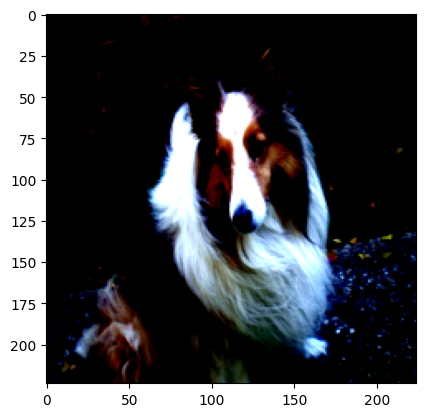

In [36]:
plt.imshow(batch_images[2].cpu().permute((1,2,0)).numpy())

In [27]:

@torch.no_grad()
def get_heatmap(
          image,
          model,
          sparse_autoencoder,
          feature_id,
): 
    image = image.to(cfg.device)
    _, cache = model.run_with_cache(image.unsqueeze(0))

    post_reshaped = einops.rearrange(cache[sparse_autoencoder.cfg.hook_point], "batch seq d_mlp -> (batch seq) d_mlp")
    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code is copied from the first part of the 'forward' method of the AutoEncoder class
    sae_in =  post_reshaped - sparse_autoencoder.b_dec # Remove decoder bias as per Anthropic
    print(f"sae_in.shape: {sae_in.shape}")
    acts = einops.einsum(
            sae_in,
            sparse_autoencoder.W_enc[:, feature_id],
            "x d_in, d_in -> x",
        )
    return acts 
     
def image_patch_heatmap(activation_values,image_size=224, pixel_num=14):
    activation_values = activation_values.detach().cpu().numpy()
    activation_values = activation_values[1:]
    activation_values = activation_values.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values[i, j]

    return heatmap


sae_in.shape: torch.Size([50, 768])


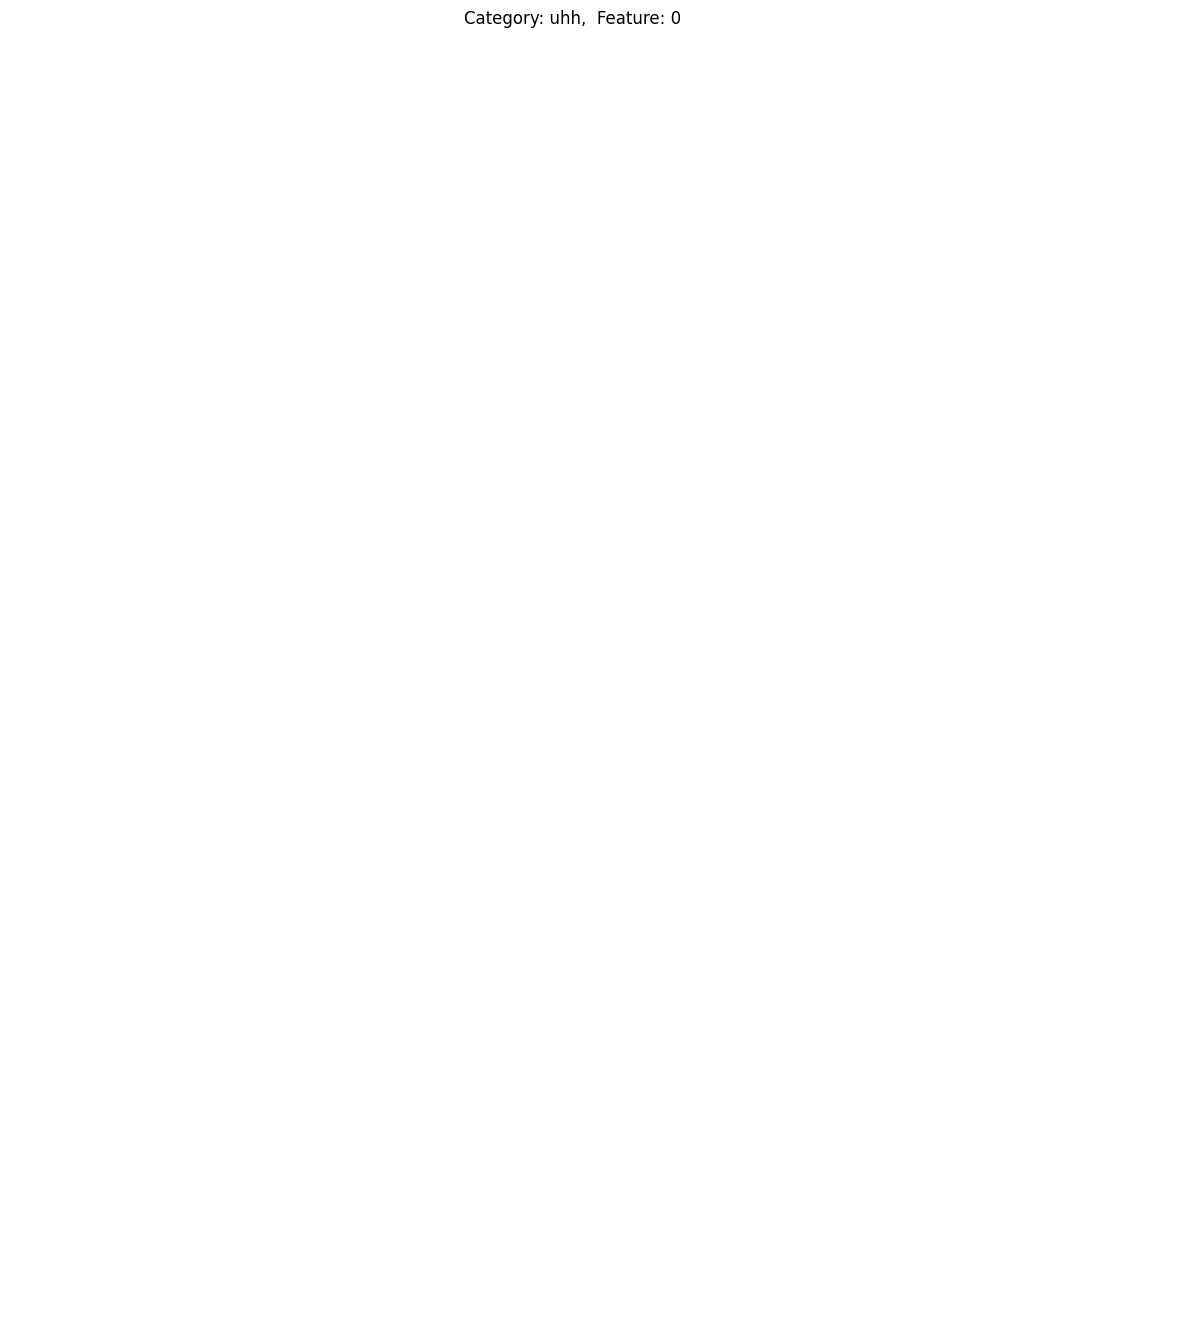

In [38]:
from matplotlib import pyplot as plt

grid_size = 1
fig, axs = plt.subplots(int(np.ceil(len(images)/grid_size)), grid_size, figsize=(15, 15))
name=  f"Category: uhh,  Feature: {0}"
fig.suptitle(name)#, y=0.95)
for ax in axs.flatten():
    ax.axis('off')
complete_bid = []

heatmap = get_heatmap(batch_images[2], model,sparse_autoencoder, 10000)
heatmap = image_patch_heatmap(heatmap, pixel_num=224//cfg.patch_size)

display = batch_images[2].cpu().numpy().transpose(1, 2, 0)

has_zero = False

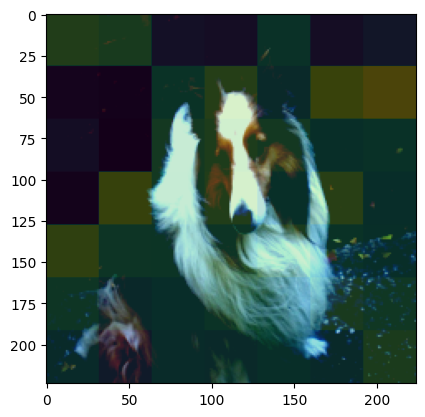

In [35]:
plt.imshow(display)
plt.imshow(heatmap, alpha=0.3)

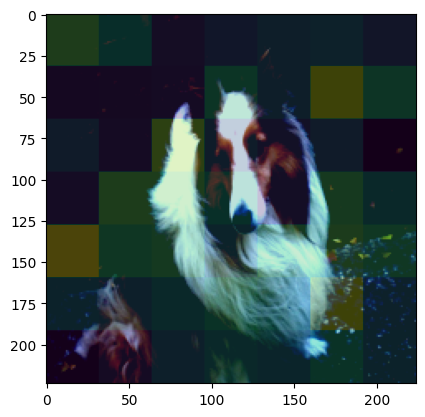

In [39]:
plt.imshow(display)
plt.imshow(heatmap, alpha=0.3)

# Potentially useful later

In [43]:
# avg neuron entropy:
avg_entropy = 0
for key, counter in feat_autolabels.items():
    entropy = 0
    x = torch.nn.functional.softmax(torch.Tensor(list(counter.values())))
    avg_entropy += -(x * x.log()).sum(dim=-1)
avg_entropy /= len(feat_autolabels)
avg_entropy

/tmp/ipykernel_17424/3566767461.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.softmax(torch.Tensor(list(counter.values())))


tensor(3.3223)

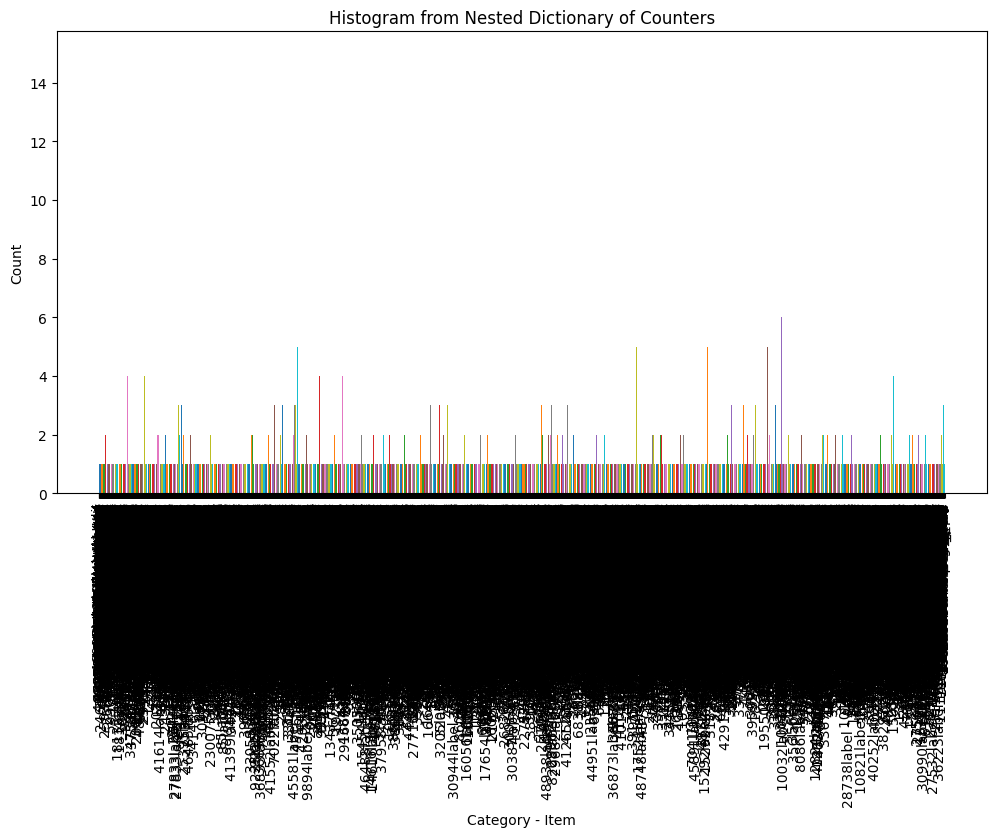

In [40]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_histogram_from_nested_counters(nested_counters):
    """
    Plot a histogram from a nested dictionary of counters.
    
    Parameters:
    nested_counters (dict): A dictionary where the keys are the main categories and the values are Counter objects.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (category, counters) in enumerate(nested_counters.items()):
        labels = list(counters.keys())
        values = list(counters.values())
        ax.bar([f"{category} - {label}" for label in labels], values, color=f"C{i}")

    # Add labels and title
    ax.set_xlabel('Category - Item')
    ax.set_ylabel('Count')
    ax.set_title('Histogram from Nested Dictionary of Counters')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    plt.show()

plot_histogram_from_nested_counters(feat_autolabels)

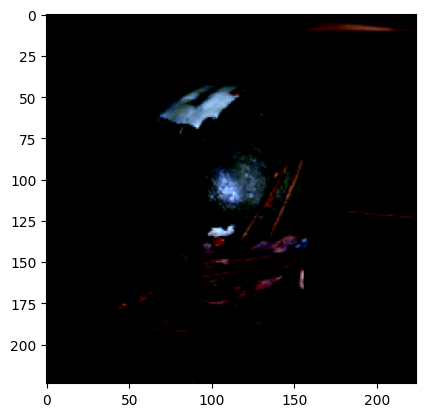

In [79]:
plt.imshow(images[44].permute((1,2,0)).numpy())

### Hierarchical Clustering on MAIs

In [ ]:
# load maximally activating images

In [ ]:
# iterate through directories

In [20]:
os.listdir(cfg.max_image_output_folder)

['TOTAL_logfreq_[-8,-6]',
 'TOTAL_logfreq_[-6,-5]',
 'TOTAL_logfreq_[-5,-4]',
 'TOTAL_logfreq_[-4,-3]',
 'TOTAL_logfreq_[-3,-2]',
 'TOTAL_logfreq_[-2,-1]',
 'TOTAL_logfreq_[-∞,-8]',
 'TOTAL_logfreq_[-1,∞]']

In [66]:
from PIL import Image
import os
import IPython


dir_feat_sets = {}
feat_ids_by_band = {}
feat_ids = []
imgnet_labels = []
ds_ids = []
feature_ma_image_embeds_full = []
for dir_name in ['TOTAL_logfreq_[-2,-1]']:
    print(os.listdir(cfg.max_image_output_folder + "/" + dir_name))
    print(len(os.listdir(cfg.max_image_output_folder + "/" + dir_name)))
    images = []
    img_dir = cfg.max_image_output_folder + "/" + dir_name
    i = 0
    dir_feats = set()
    for imagefile in os.listdir(img_dir)[:1000]:
        print(i)
        print(imagefile)
        _, feat_id, imgnet_label, ds_id = imagefile.split(":")
        feat_ids_by_band[feat_id] = dir_name
        dir_feats.add(feat_id)
        feat_ids.append(feat_id)
        imgnet_labels.append(imgnet_label)
        ds_ids.append(ds_id)
        i += 1
        IPython.display.Image(img_dir + "/" +imagefile)
        image = preproc(Image.open(img_dir + "/" + imagefile))
        images.append(image)
    with torch.no_grad(), torch.cuda.amp.autocast():
        feature_ma_image_embeds_full.append(og_model.cuda().encode_image(torch.stack(images).cuda()))
    dir_feat_sets[dir_name] = dir_feats

['neglogfreq_6.397940158843994feauture_id:27991label:pillowbid:28243.png', 'neglogfreq_6.397940158843994feauture_id:27991label:washbasinbid:24625.png', 'neglogfreq_6.397940158843994feauture_id:27991label:ostrichbid:49089.png', 'neglogfreq_6.397940158843994feauture_id:27991label:pillowbid:46169.png', 'neglogfreq_6.397940158843994feauture_id:27991label:yurtbid:9583.png', 'neglogfreq_6.397940158843994feauture_id:27991label:coral_fungusbid:953.png', 'neglogfreq_6.397940158843994feauture_id:27991label:cheetahbid:3772.png', 'neglogfreq_6.397940158843994feauture_id:27991label:king_penguinbid:46965.png', 'neglogfreq_6.397940158843994feauture_id:27991label:microphonebid:10803.png', 'neglogfreq_6.397940158843994feauture_id:27991label:water_ouzelbid:6906.png', 'neglogfreq_6.397940158843994feauture_id:27991label:mosquito_netbid:35221.png', 'neglogfreq_6.397940158843994feauture_id:27991label:whistlebid:46146.png', 'neglogfreq_6.397940158843994feauture_id:27991label:valleybid:32344.png', 'neglogfreq

21
neglogfreq_6.09691047668457feauture_id:22657label:spider_webbid:12304.png
22
neglogfreq_6.09691047668457feauture_id:22657label:ice_creambid:15353.png
23
neglogfreq_6.09691047668457feauture_id:22657label:platypusbid:16322.png
24
neglogfreq_6.09691047668457feauture_id:22657label:reelbid:21833.png
25
neglogfreq_6.09691047668457feauture_id:22657label:combination_lockbid:21745.png
26
neglogfreq_6.09691047668457feauture_id:22657label:combination_lockbid:32486.png
27
neglogfreq_6.09691047668457feauture_id:22657label:screenbid:42891.png
28
neglogfreq_6.09691047668457feauture_id:22657label:nematodebid:4922.png
29
neglogfreq_6.09691047668457feauture_id:22657label:little_blue_heronbid:45818.png
30
neglogfreq_6.09691047668457feauture_id:22657label:flamingobid:37830.png
31
neglogfreq_6.09691047668457feauture_id:22657label:sundialbid:31307.png
32
neglogfreq_6.397940158843994feauture_id:6785label:power_drillbid:26147.png
33
neglogfreq_6.397940158843994feauture_id:6785label:palacebid:30766.png
34
n

131
neglogfreq_6.397940158843994feauture_id:40013label:fur_coatbid:31172.png
132
neglogfreq_6.397940158843994feauture_id:40013label:chainlink_fencebid:1093.png
133
neglogfreq_6.397940158843994feauture_id:40013label:amphibianbid:34842.png
134
neglogfreq_6.397940158843994feauture_id:40013label:planetariumbid:45684.png
135
neglogfreq_6.397940158843994feauture_id:40013label:fur_coatbid:640.png
136
neglogfreq_6.397940158843994feauture_id:40013label:cannonbid:19074.png
137
neglogfreq_6.397940158843994feauture_id:40013label:Scotch_terrierbid:3231.png
138
neglogfreq_6.397940158843994feauture_id:40013label:breastplatebid:16868.png
139
neglogfreq_6.397940158843994feauture_id:40013label:jellyfishbid:27270.png
140
neglogfreq_6.397940158843994feauture_id:40013label:cupbid:26173.png
141
neglogfreq_6.397940158843994feauture_id:40013label:fur_coatbid:21885.png
142
neglogfreq_6.397940158843994feauture_id:40013label:airshipbid:37583.png
143
neglogfreq_6.397940158843994feauture_id:40013label:toilet_tissu

244
neglogfreq_6.397940158843994feauture_id:16996label:daisybid:4919.png
245
neglogfreq_6.397940158843994feauture_id:16996label:tobacco_shopbid:18547.png
246
neglogfreq_6.397940158843994feauture_id:16996label:sandbarbid:47283.png
247
neglogfreq_6.397940158843994feauture_id:16996label:traybid:22285.png
248
neglogfreq_6.397940158843994feauture_id:16996label:wolf_spiderbid:17789.png
249
neglogfreq_6.397940158843994feauture_id:16996label:volcanobid:40298.png
250
neglogfreq_6.397940158843994feauture_id:16996label:binderbid:41697.png
251
neglogfreq_6.397940158843994feauture_id:16996label:cratebid:5740.png
252
neglogfreq_6.397940158843994feauture_id:16996label:alpbid:43502.png
253
neglogfreq_6.397940158843994feauture_id:16996label:volcanobid:10640.png
254
neglogfreq_6.397940158843994feauture_id:16996label:pay_phonebid:46468.png
255
neglogfreq_6.397940158843994feauture_id:16996label:punching_bagbid:48983.png
256
neglogfreq_6.09691047668457feauture_id:42509label:wolf_spiderbid:17985.png
257
neg

356
neglogfreq_6.397940158843994feauture_id:20588label:guacamolebid:24911.png
357
neglogfreq_6.397940158843994feauture_id:20588label:Saint_Bernardbid:43280.png
358
neglogfreq_6.397940158843994feauture_id:20588label:radiatorbid:34868.png
359
neglogfreq_6.397940158843994feauture_id:20588label:maillotbid:9882.png
360
neglogfreq_6.397940158843994feauture_id:20588label:steam_locomotivebid:34022.png
361
neglogfreq_6.397940158843994feauture_id:20588label:boxerbid:26881.png
362
neglogfreq_6.397940158843994feauture_id:20588label:restaurantbid:18335.png
363
neglogfreq_6.397940158843994feauture_id:20588label:motor_scooterbid:46854.png
364
neglogfreq_6.397940158843994feauture_id:20588label:flatwormbid:32763.png
365
neglogfreq_6.397940158843994feauture_id:20588label:lionfishbid:20621.png
366
neglogfreq_6.397940158843994feauture_id:20588label:menubid:26996.png
367
neglogfreq_6.397940158843994feauture_id:20588label:flatwormbid:20125.png
368
neglogfreq_6.397940158843994feauture_id:9500label:earbid:423

465
neglogfreq_6.397940158843994feauture_id:43970label:frying_panbid:17769.png
466
neglogfreq_6.397940158843994feauture_id:43970label:hair_spraybid:3173.png
467
neglogfreq_6.397940158843994feauture_id:43970label:analog_clockbid:5489.png
468
neglogfreq_6.397940158843994feauture_id:43970label:radiatorbid:769.png
469
neglogfreq_6.397940158843994feauture_id:43970label:wombatbid:47618.png
470
neglogfreq_6.397940158843994feauture_id:43970label:volcanobid:22424.png
471
neglogfreq_6.397940158843994feauture_id:43970label:restaurantbid:49098.png
472
neglogfreq_6.397940158843994feauture_id:43970label:doormatbid:34104.png
473
neglogfreq_6.397940158843994feauture_id:43970label:guenonbid:6409.png
474
neglogfreq_6.397940158843994feauture_id:43970label:cauliflowerbid:6311.png
475
neglogfreq_6.397940158843994feauture_id:43970label:bell_cotebid:33060.png
476
neglogfreq_6.397940158843994feauture_id:43970label:packetbid:2068.png
477
neglogfreq_6.397940158843994feauture_id:43970label:mantisbid:21365.png
47

589
neglogfreq_6.397940158843994feauture_id:37851label:beaverbid:12618.png
590
neglogfreq_6.397940158843994feauture_id:37851label:washbasinbid:45790.png
591
neglogfreq_6.397940158843994feauture_id:37851label:eelbid:30259.png
592
neglogfreq_6.09691047668457feauture_id:35188label:tile_roofbid:32740.png
593
neglogfreq_6.09691047668457feauture_id:35188label:Model_Tbid:39197.png
594
neglogfreq_6.09691047668457feauture_id:35188label:table_lampbid:40161.png
595
neglogfreq_6.09691047668457feauture_id:35188label:plungerbid:46399.png
596
neglogfreq_6.09691047668457feauture_id:35188label:bearskinbid:35800.png
597
neglogfreq_6.09691047668457feauture_id:35188label:lampshadebid:43759.png
598
neglogfreq_6.09691047668457feauture_id:35188label:power_drillbid:26147.png
599
neglogfreq_6.09691047668457feauture_id:35188label:prayer_rugbid:49805.png
600
neglogfreq_6.09691047668457feauture_id:35188label:palacebid:30766.png
601
neglogfreq_6.09691047668457feauture_id:35188label:polebid:6102.png
602
neglogfreq_

701
neglogfreq_6.397940158843994feauture_id:636label:badgerbid:28237.png
702
neglogfreq_6.397940158843994feauture_id:636label:Rhodesian_ridgebackbid:43076.png
703
neglogfreq_6.397940158843994feauture_id:636label:Appenzellerbid:25495.png
704
neglogfreq_6.397940158843994feauture_id:636label:Australian_terrierbid:39700.png
705
neglogfreq_6.397940158843994feauture_id:30114label:syringebid:34015.png
706
neglogfreq_6.397940158843994feauture_id:30114label:daisybid:23820.png
707
neglogfreq_6.397940158843994feauture_id:30114label:menubid:26996.png
708
neglogfreq_6.397940158843994feauture_id:30114label:typewriter_keyboardbid:13265.png
709
neglogfreq_6.397940158843994feauture_id:30114label:screwdriverbid:14705.png
710
neglogfreq_6.397940158843994feauture_id:30114label:spatulabid:47765.png
711
neglogfreq_6.397940158843994feauture_id:30114label:web_sitebid:22113.png
712
neglogfreq_6.397940158843994feauture_id:30114label:American_egretbid:19018.png
713
neglogfreq_6.397940158843994feauture_id:30114la

809
neglogfreq_6.397940158843994feauture_id:35529label:fire_screenbid:11809.png
810
neglogfreq_6.397940158843994feauture_id:35529label:walking_stickbid:2013.png
811
neglogfreq_6.397940158843994feauture_id:35529label:orangutanbid:12781.png
812
neglogfreq_6.397940158843994feauture_id:35529label:dining_tablebid:13686.png
813
neglogfreq_6.397940158843994feauture_id:35529label:cradlebid:1863.png
814
neglogfreq_6.397940158843994feauture_id:35529label:grand_pianobid:18953.png
815
neglogfreq_6.397940158843994feauture_id:35529label:mosquebid:5360.png
816
neglogfreq_6.397940158843994feauture_id:35529label:red_winebid:10342.png
817
neglogfreq_6.09691047668457feauture_id:16898label:ostrichbid:23606.png
818
neglogfreq_6.09691047668457feauture_id:16898label:albatrossbid:38863.png
819
neglogfreq_6.09691047668457feauture_id:16898label:white_storkbid:1276.png
820
neglogfreq_6.09691047668457feauture_id:16898label:ostrichbid:17838.png
821
neglogfreq_6.09691047668457feauture_id:16898label:ostrichbid:33180

917
neglogfreq_6.397940158843994feauture_id:32230label:cornbid:41541.png
918
neglogfreq_6.397940158843994feauture_id:32230label:cheeseburgerbid:32810.png
919
neglogfreq_6.397940158843994feauture_id:32230label:cauliflowerbid:21439.png
920
neglogfreq_6.397940158843994feauture_id:32230label:cornbid:11593.png
921
neglogfreq_6.397940158843994feauture_id:32230label:tobacco_shopbid:10183.png
922
neglogfreq_6.397940158843994feauture_id:32230label:cabbage_butterflybid:39029.png
923
neglogfreq_6.397940158843994feauture_id:32230label:earbid:29870.png
924
neglogfreq_6.397940158843994feauture_id:32230label:guillotinebid:42451.png
925
neglogfreq_6.397940158843994feauture_id:32230label:timber_wolfbid:37117.png
926
neglogfreq_6.397940158843994feauture_id:32230label:African_greybid:44883.png
927
neglogfreq_6.397940158843994feauture_id:32230label:cowboy_hatbid:24378.png
928
neglogfreq_6.397940158843994feauture_id:32230label:earbid:39372.png
929
neglogfreq_6.397940158843994feauture_id:32230label:miniskir

15
neglogfreq_1.9688340425491333feauture_id:46905label:candlebid:25085.png
16
neglogfreq_1.683434247970581feauture_id:24679label:prairie_chickenbid:20238.png
17
neglogfreq_1.683434247970581feauture_id:24679label:cranebid:6427.png
18
neglogfreq_1.683434247970581feauture_id:24679label:coilbid:46330.png
19
neglogfreq_1.683434247970581feauture_id:24679label:prairie_chickenbid:17429.png
20
neglogfreq_1.683434247970581feauture_id:24679label:impalabid:43783.png
21
neglogfreq_1.683434247970581feauture_id:24679label:hartebeestbid:46721.png
22
neglogfreq_1.683434247970581feauture_id:24679label:promontorybid:35569.png
23
neglogfreq_1.683434247970581feauture_id:24679label:lemonbid:28822.png
24
neglogfreq_1.683434247970581feauture_id:24679label:Shetland_sheepdogbid:1970.png
25
neglogfreq_1.683434247970581feauture_id:24679label:squirrel_monkeybid:37239.png
26
neglogfreq_1.683434247970581feauture_id:24679label:monasterybid:811.png
27
neglogfreq_1.683434247970581feauture_id:24679label:speedboatbid:463

131
neglogfreq_1.6109473705291748feauture_id:18688label:jack_o__lanternbid:28059.png
132
neglogfreq_1.6109473705291748feauture_id:18688label:brassierebid:7483.png
133
neglogfreq_1.6109473705291748feauture_id:18688label:stingraybid:4872.png
134
neglogfreq_1.6109473705291748feauture_id:18688label:broccolibid:38203.png
135
neglogfreq_1.6109473705291748feauture_id:18688label:handkerchiefbid:48408.png
136
neglogfreq_1.6109473705291748feauture_id:18688label:American_alligatorbid:22521.png
137
neglogfreq_1.6109473705291748feauture_id:18688label:wooden_spoonbid:8201.png
138
neglogfreq_1.6109473705291748feauture_id:18688label:washbasinbid:13522.png
139
neglogfreq_1.6109473705291748feauture_id:18688label:zebrabid:24007.png
140
neglogfreq_1.6109473705291748feauture_id:18688label:radiatorbid:17546.png
141
neglogfreq_1.6109473705291748feauture_id:18688label:quiltbid:48319.png
142
neglogfreq_1.6109473705291748feauture_id:18688label:envelopebid:21509.png
143
neglogfreq_1.6109473705291748feauture_id:1

244
neglogfreq_1.7389371395111084feauture_id:24765label:house_finchbid:15829.png
245
neglogfreq_1.7389371395111084feauture_id:24765label:Dutch_ovenbid:43854.png
246
neglogfreq_1.7389371395111084feauture_id:24765label:hourglassbid:23966.png
247
neglogfreq_1.7389371395111084feauture_id:24765label:Irish_water_spanielbid:13758.png
248
neglogfreq_1.7389371395111084feauture_id:24765label:butternut_squashbid:35219.png
249
neglogfreq_1.7389371395111084feauture_id:24765label:lumbermillbid:6141.png
250
neglogfreq_1.7389371395111084feauture_id:24765label:traybid:4805.png
251
neglogfreq_1.7389371395111084feauture_id:24765label:butternut_squashbid:32115.png
252
neglogfreq_1.7389371395111084feauture_id:24765label:cratebid:27542.png
253
neglogfreq_1.7389371395111084feauture_id:24765label:fox_squirrelbid:49287.png
254
neglogfreq_1.7389371395111084feauture_id:24765label:bell_pepperbid:38871.png
255
neglogfreq_1.7389371395111084feauture_id:24765label:cheeseburgerbid:16998.png
256
neglogfreq_1.8996571302

352
neglogfreq_1.9971777200698853feauture_id:34942label:window_screenbid:22777.png
353
neglogfreq_1.9971777200698853feauture_id:34942label:pizzabid:12242.png
354
neglogfreq_1.9971777200698853feauture_id:34942label:strainerbid:17350.png
355
neglogfreq_1.9971777200698853feauture_id:34942label:tiger_catbid:3294.png
356
neglogfreq_1.9971777200698853feauture_id:34942label:bath_towelbid:48416.png
357
neglogfreq_1.9971777200698853feauture_id:34942label:bitternbid:44564.png
358
neglogfreq_1.9971777200698853feauture_id:34942label:greenhousebid:2473.png
359
neglogfreq_1.9971777200698853feauture_id:34942label:Petri_dishbid:39323.png
360
neglogfreq_1.9971777200698853feauture_id:34942label:haybid:44238.png
361
neglogfreq_1.9971777200698853feauture_id:34942label:European_fire_salamanderbid:28564.png
362
neglogfreq_1.9971777200698853feauture_id:34942label:stupabid:22822.png
363
neglogfreq_1.9971777200698853feauture_id:34942label:water_jugbid:5080.png
364
neglogfreq_1.9971777200698853feauture_id:34942

463
neglogfreq_1.620854139328003feauture_id:29459label:bloodhoundbid:9962.png
464
neglogfreq_1.6946659088134766feauture_id:28390label:bannisterbid:48425.png
465
neglogfreq_1.6946659088134766feauture_id:28390label:geyserbid:42471.png
466
neglogfreq_1.6946659088134766feauture_id:28390label:lakesidebid:20068.png
467
neglogfreq_1.6946659088134766feauture_id:28390label:scalebid:35229.png
468
neglogfreq_1.6946659088134766feauture_id:28390label:centipedebid:38503.png
469
neglogfreq_1.6946659088134766feauture_id:28390label:hogbid:17373.png
470
neglogfreq_1.6946659088134766feauture_id:28390label:spider_webbid:46666.png
471
neglogfreq_1.6946659088134766feauture_id:28390label:guillotinebid:26033.png
472
neglogfreq_1.6946659088134766feauture_id:28390label:nematodebid:1881.png
473
neglogfreq_1.6946659088134766feauture_id:28390label:mailboxbid:24782.png
474
neglogfreq_1.6946659088134766feauture_id:28390label:radio_telescopebid:39751.png
475
neglogfreq_1.6946659088134766feauture_id:28390label:chainli

577
neglogfreq_1.6131017208099365feauture_id:20728label:lemonbid:30966.png
578
neglogfreq_1.6131017208099365feauture_id:20728label:packetbid:11689.png
579
neglogfreq_1.6131017208099365feauture_id:20728label:burritobid:45722.png
580
neglogfreq_1.6131017208099365feauture_id:20728label:cratebid:20676.png
581
neglogfreq_1.6131017208099365feauture_id:20728label:bagelbid:28892.png
582
neglogfreq_1.6131017208099365feauture_id:20728label:hen_of_the_woodsbid:2536.png
583
neglogfreq_1.6131017208099365feauture_id:20728label:black_footed_ferretbid:1508.png
584
neglogfreq_1.6131017208099365feauture_id:20728label:plastic_bagbid:35197.png
585
neglogfreq_1.6131017208099365feauture_id:20728label:pretzelbid:29961.png
586
neglogfreq_1.6131017208099365feauture_id:20728label:plastic_bagbid:42739.png
587
neglogfreq_1.6131017208099365feauture_id:20728label:hotdogbid:16178.png
588
neglogfreq_1.6131017208099365feauture_id:20728label:chocolate_saucebid:4934.png
589
neglogfreq_1.6131017208099365feauture_id:20728

684
neglogfreq_1.8757306337356567feauture_id:20703label:stovebid:46913.png
685
neglogfreq_1.8757306337356567feauture_id:20703label:radiobid:35361.png
686
neglogfreq_1.8757306337356567feauture_id:20703label:mailbagbid:7847.png
687
neglogfreq_1.8757306337356567feauture_id:20703label:walletbid:21288.png
688
neglogfreq_1.9380501508712769feauture_id:23828label:mud_turtlebid:49702.png
689
neglogfreq_1.9380501508712769feauture_id:23828label:cohobid:15545.png
690
neglogfreq_1.9380501508712769feauture_id:23828label:centipedebid:44648.png
691
neglogfreq_1.9380501508712769feauture_id:23828label:black_widowbid:44675.png
692
neglogfreq_1.9380501508712769feauture_id:23828label:coral_fungusbid:24124.png
693
neglogfreq_1.9380501508712769feauture_id:23828label:nailbid:48966.png
694
neglogfreq_1.9380501508712769feauture_id:23828label:crayfishbid:11977.png
695
neglogfreq_1.9380501508712769feauture_id:23828label:slugbid:27531.png
696
neglogfreq_1.9380501508712769feauture_id:23828label:cliffbid:47654.png
6

794
neglogfreq_1.6394597291946411feauture_id:13436label:triceratopsbid:17961.png
795
neglogfreq_1.6394597291946411feauture_id:13436label:conchbid:9729.png
796
neglogfreq_1.6394597291946411feauture_id:13436label:feather_boabid:31269.png
797
neglogfreq_1.6394597291946411feauture_id:13436label:gasmaskbid:31676.png
798
neglogfreq_1.6394597291946411feauture_id:13436label:running_shoebid:29042.png
799
neglogfreq_1.6394597291946411feauture_id:13436label:green_lizardbid:41068.png
800
neglogfreq_1.6852229833602905feauture_id:40294label:stolebid:45761.png
801
neglogfreq_1.6852229833602905feauture_id:40294label:shower_curtainbid:26833.png
802
neglogfreq_1.6852229833602905feauture_id:40294label:overskirtbid:19175.png
803
neglogfreq_1.6852229833602905feauture_id:40294label:redbonebid:28005.png
804
neglogfreq_1.6852229833602905feauture_id:40294label:quiltbid:23637.png
805
neglogfreq_1.6852229833602905feauture_id:40294label:ponchobid:48172.png
806
neglogfreq_1.6852229833602905feauture_id:40294label:s

908
neglogfreq_1.468260645866394feauture_id:18987label:snailbid:23205.png
909
neglogfreq_1.468260645866394feauture_id:18987label:ladlebid:9884.png
910
neglogfreq_1.468260645866394feauture_id:18987label:guacamolebid:13426.png
911
neglogfreq_1.468260645866394feauture_id:18987label:candlebid:48527.png
912
neglogfreq_1.9630837440490723feauture_id:37286label:cornbid:8647.png
913
neglogfreq_1.9630837440490723feauture_id:37286label:cornbid:41541.png
914
neglogfreq_1.9630837440490723feauture_id:37286label:earbid:8439.png
915
neglogfreq_1.9630837440490723feauture_id:37286label:earbid:8280.png
916
neglogfreq_1.9630837440490723feauture_id:37286label:earbid:43988.png
917
neglogfreq_1.9630837440490723feauture_id:37286label:earbid:22465.png
918
neglogfreq_1.9630837440490723feauture_id:37286label:cornbid:7467.png
919
neglogfreq_1.9630837440490723feauture_id:37286label:cornbid:10323.png
920
neglogfreq_1.9630837440490723feauture_id:37286label:earbid:25078.png
921
neglogfreq_1.9630837440490723feauture_i

In [67]:
feature_ma_image_embeds = torch.cat(feature_ma_image_embeds_full,dim=0)

In [69]:
set.intersection(dir_feat_sets['TOTAL_logfreq_[-8,-6]'], dir_feat_sets['TOTAL_logfreq_[-2,-1]'])

set()

In [70]:
feat_ids_by_band

{'27991label': 'TOTAL_logfreq_[-8,-6]',
 '22657label': 'TOTAL_logfreq_[-8,-6]',
 '6785label': 'TOTAL_logfreq_[-8,-6]',
 '25437label': 'TOTAL_logfreq_[-8,-6]',
 '15541label': 'TOTAL_logfreq_[-8,-6]',
 '13199label': 'TOTAL_logfreq_[-8,-6]',
 '34222label': 'TOTAL_logfreq_[-8,-6]',
 '43670label': 'TOTAL_logfreq_[-8,-6]',
 '40013label': 'TOTAL_logfreq_[-8,-6]',
 '19400label': 'TOTAL_logfreq_[-8,-6]',
 '41239label': 'TOTAL_logfreq_[-8,-6]',
 '31511label': 'TOTAL_logfreq_[-8,-6]',
 '43508label': 'TOTAL_logfreq_[-8,-6]',
 '11507label': 'TOTAL_logfreq_[-8,-6]',
 '47056label': 'TOTAL_logfreq_[-8,-6]',
 '16996label': 'TOTAL_logfreq_[-8,-6]',
 '42509label': 'TOTAL_logfreq_[-8,-6]',
 '5585label': 'TOTAL_logfreq_[-8,-6]',
 '4174label': 'TOTAL_logfreq_[-8,-6]',
 '25687label': 'TOTAL_logfreq_[-8,-6]',
 '30360label': 'TOTAL_logfreq_[-8,-6]',
 '30205label': 'TOTAL_logfreq_[-8,-6]',
 '20588label': 'TOTAL_logfreq_[-8,-6]',
 '9500label': 'TOTAL_logfreq_[-8,-6]',
 '38858label': 'TOTAL_logfreq_[-8,-6]',
 '39

In [73]:
len(dir_feat_sets['TOTAL_logfreq_[-8,-6]']), len(dir_feat_sets['TOTAL_logfreq_[-2,-1]'])

(65, 63)

In [74]:
feat_ids

['27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '27991label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '22657label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '6785label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '25437label',
 '15541label',
 '15541label',
 '15541label',
 '15541labe

In [75]:
feat_band_by_idx = [f"{feat_ids_by_band[feat_id]},{imgnet_labels[i]}" for i, feat_id in enumerate(feat_ids)]


In [101]:
feat_band_by_idx_only = [f"{feat_ids_by_band[feat_id]}" for i, feat_id in enumerate(feat_ids)]


In [50]:
# feat_ids = [int(feat_id[:-5]) for feat_id in feat_ids]
# imgnet_labels = [label[:-3] for label in imgnet_labels]
# ds_ids = [int(ds_id[:-4]) for ds_id in ds_ids]

In [106]:
len(set(imgnet_labels))

769

In [23]:
dir_name = os.listdir(cfg.max_image_output_folder)[0]
img_dir = cfg.max_image_output_folder + "/" + dir_name
for imagefile in os.listdir(img_dir):
    IPython.display.Image(img_dir + "/" +imagefile)

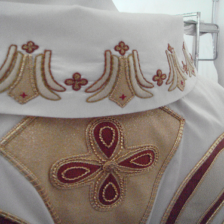

In [76]:
IPython.display.Image(img_dir + "/" + imagefile)

In [77]:
feature_ma_image_embeds.shape

torch.Size([2000, 512])

In [78]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(feature_ma_image_embeds.cpu(), 'single')

In [80]:
fig = plt.figure(figsize=(150, 60))
dn = dendrogram(Z, labels=feat_band_by_idx)
plt.show()


In [107]:
import scipy
what, alsowhat = scipy.cluster.vq.kmeans(feature_ma_image_embeds.cpu().float(), 769)

In [108]:
what.shape

(744, 512)

In [111]:
torch_what = torch.Tensor(what)

In [ ]:
from collections import defaultdict
vec_sets = defaultdict(list)
vec_sets_lowest = {}
vec_sets_lowest_label = {}
for label, vector in zip(feat_band_by_idx, feature_ma_image_embeds.cpu().float()):
    print(label)
    # get argmin of k means
    res = torch.cdist(vector[None,:].cuda(), torch_what.cuda(), p=2.0).squeeze()
    print(res.shape)
    closest_mean = torch.argmin(res)
    vec_sets[int(closest_mean.cpu())].append(label)
    if int(closest_mean.cpu()) not in vec_sets_lowest:
        vec_sets_lowest[int(closest_mean.cpu())] = res[int(closest_mean.cpu())]
        vec_sets_lowest_label[int(closest_mean.cpu())] = label
    elif vec_sets_lowest[int(closest_mean.cpu())] > res[int(closest_mean.cpu())]:
        vec_sets_lowest[int(closest_mean.cpu())] = res[int(closest_mean.cpu())]
        vec_sets_lowest_label[int(closest_mean.cpu())] = label


In [ ]:
vec_sets_lowest_label

In [133]:
labelctr = Counter()
for value in vec_sets_lowest_label.values():
    labelctr[value.split(",")[0]] += 1
labelctr

Counter({'TOTAL_logfreq_[-8': 387, 'TOTAL_logfreq_[-2': 357})

In [104]:
ctr

Counter({'TOTAL_logfreq_[-8,-6]': 645, 'TOTAL_logfreq_[-2,-1]': 568})

In [ ]:
from collections import Counter
ctr = Counter()
for label, vector in zip(feat_band_by_idx_only, feature_ma_image_embeds.cpu().float()):
    print(label)
    if torch.norm(vector - what[0], 2) < torch.norm(vector - what[1],2):
        ctr[label] += 1